###### Татур А.А.
###### ДЗ_18 часть 1. Кластеризация изображений
###### v0.1
###### 07.12.22
###### Dataset: https://www.kaggle.com/datasets/862ae86edba271c39f76d0b530edeb55076b4b82b971160637210900747c44b1 (Частично. три группы изображений)
###### Инструменты обработки - Понижение размерности PCA, HOG. Embedding - TSNE.

#### Цели:

1. Из небольшого объема исходных изображений (картинок) с использованием алгоритмов кластеризации найти похожие. 
2. В выводах обосновать какие метрики и алгоритмы лучше использовать для решения вышеизложенных задач.


###### Задачи

1. Загрузка изображений
2. Привести их в одноцветный режим, векторизировать.
3. Понижение размерности, эмбединг
4. Кластеризация различными методами
5. Выводы

In [665]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from skimage import io


from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift

from sklearn.metrics import silhouette_score, v_measure_score

###### Определяем собственные функции

###### 1. Загрузка изображений из подкаталогов

In [547]:
#### Определяем функцию, которая на вход принимает наименование каталога с изображениями, выполняет их ресайз до 256*256,
#### конвертирует из RGB в GRAY
#### На выход дает два np массива, в первом изображения, во втором наименования папок (имена классов), в которых находятся
#### изображения.

def imcat_torray(im_dir: str, new_size_x=300, new_size_y=200) -> np.array:
    '''
    Function imcat_toarray takes on input a directiry with other subdirectories that contain
    multiply images. And as output give two np.array: first vectorized resized (new_size_x)x(new_size_y)
    images, second
    array of names of subdirectories.
    
    new_size_x, int (default = 300) - size of output image in width
    new_size_y, int (defaul = 200) - size of outpt image in height
    
    '''
     
    X=[]
    y=[]
    
    for a in os.listdir(im_dir):
        link=im_dir+'\\'+a
        for b in os.listdir(link):
            im_link=link+'\\'+b
            
            if io.imread(im_link).shape[-1]==3: #Проверка. Если картинка цветная, то конвертируем в gray
                im = resize(rgb2gray(io.imread(im_link)), (new_size_x, new_size_y))
            else:
                im = resize(io.imread(im_link), (new_size_x, new_size_y)) #если картинка однотонная, то просто ресайз
            X.append(im.reshape(new_size_x*new_size_y))
            y.append(a)
            
    return np.array(X).astype(np.float16), np.array(y)

###### 2. Оценка качества кластеризации

In [477]:
def measure(X, y, predict, n_clusters=None):
    '''
        Function for clusterization model assesement. On input takes:
        X - np.array with features
        y - np.array with lables
        n_clusters - number of clusters (default = None)
    '''
    if n_clusters:
        print (' For {} clusters'.format(n_clusters))
    print ('Silhouetter score is {}'.format (silhouette_score(X, predict)))
    print ('V_score is {}'.format (v_measure_score(y, predict)))

###### 3. Feature exraction с помощью HOG

In [507]:
### Функция, конвертирующая картинку в объект HOG (Histogram of oriented gradients)
def toHog(image_vec_array:np.array, pic_size_x=300, pic_size_y=200,
         orientations=12, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True) -> np.array:
    '''
    Function takes on input vectorized as 1D array imgae and on output give np.array with vectorized HOG-picture.
    pic_size_x, int (default = 300) -  size of input image in width
    pic_size_y, int (default =200) - size of input image in height
    orientations, int (default = 12) - Number of orientation bins.
    pixels_per_cell, 2-tuple (default = (16, 16)) - Size (in pixels) of a cell.
    cells_per_block, 2-tuple (default = (1, 1)) - Number of cells in each block.
    visualize, boolean (default = True) - Also return an image of the HOG. For each cell and orientation bin, 
                                          the image contains a line segment that is centered at the cell center, 
                                          is perpendicular to the midpoint of the range of angles spanned 
                                          by the orientation bin, and has intensity proportional 
                                          to the corresponding histogram value.
    '''   
    X_hog=[]
    
    for x in range(len(image_vec_array)):
        fd, hog_image = hog(image_vec_array[x].reshape(pic_size_x,pic_size_y), 
                            orientations=orientations, 
                            pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, 
                            visualize=visualize)
        X_hog.append(hog_image.reshape(picc_size_x*pic_size_y))
    
    return  np.array(X_hog)

### Часть 1. Изображения

### I. Preprocessing

#### 1.1. Загружаем датасет с изображениями

In [635]:
X,y_label=imcat_torray('Images')
y=LabelEncoder().fit_transform(y_label)

#### 1.2. Скалирование в диапазоне 0-255

In [636]:
X_scaled = MinMaxScaler(feature_range=(0,255)).fit_transform(X)

#### 1.3. Выводим каждый 10й элемент подборки

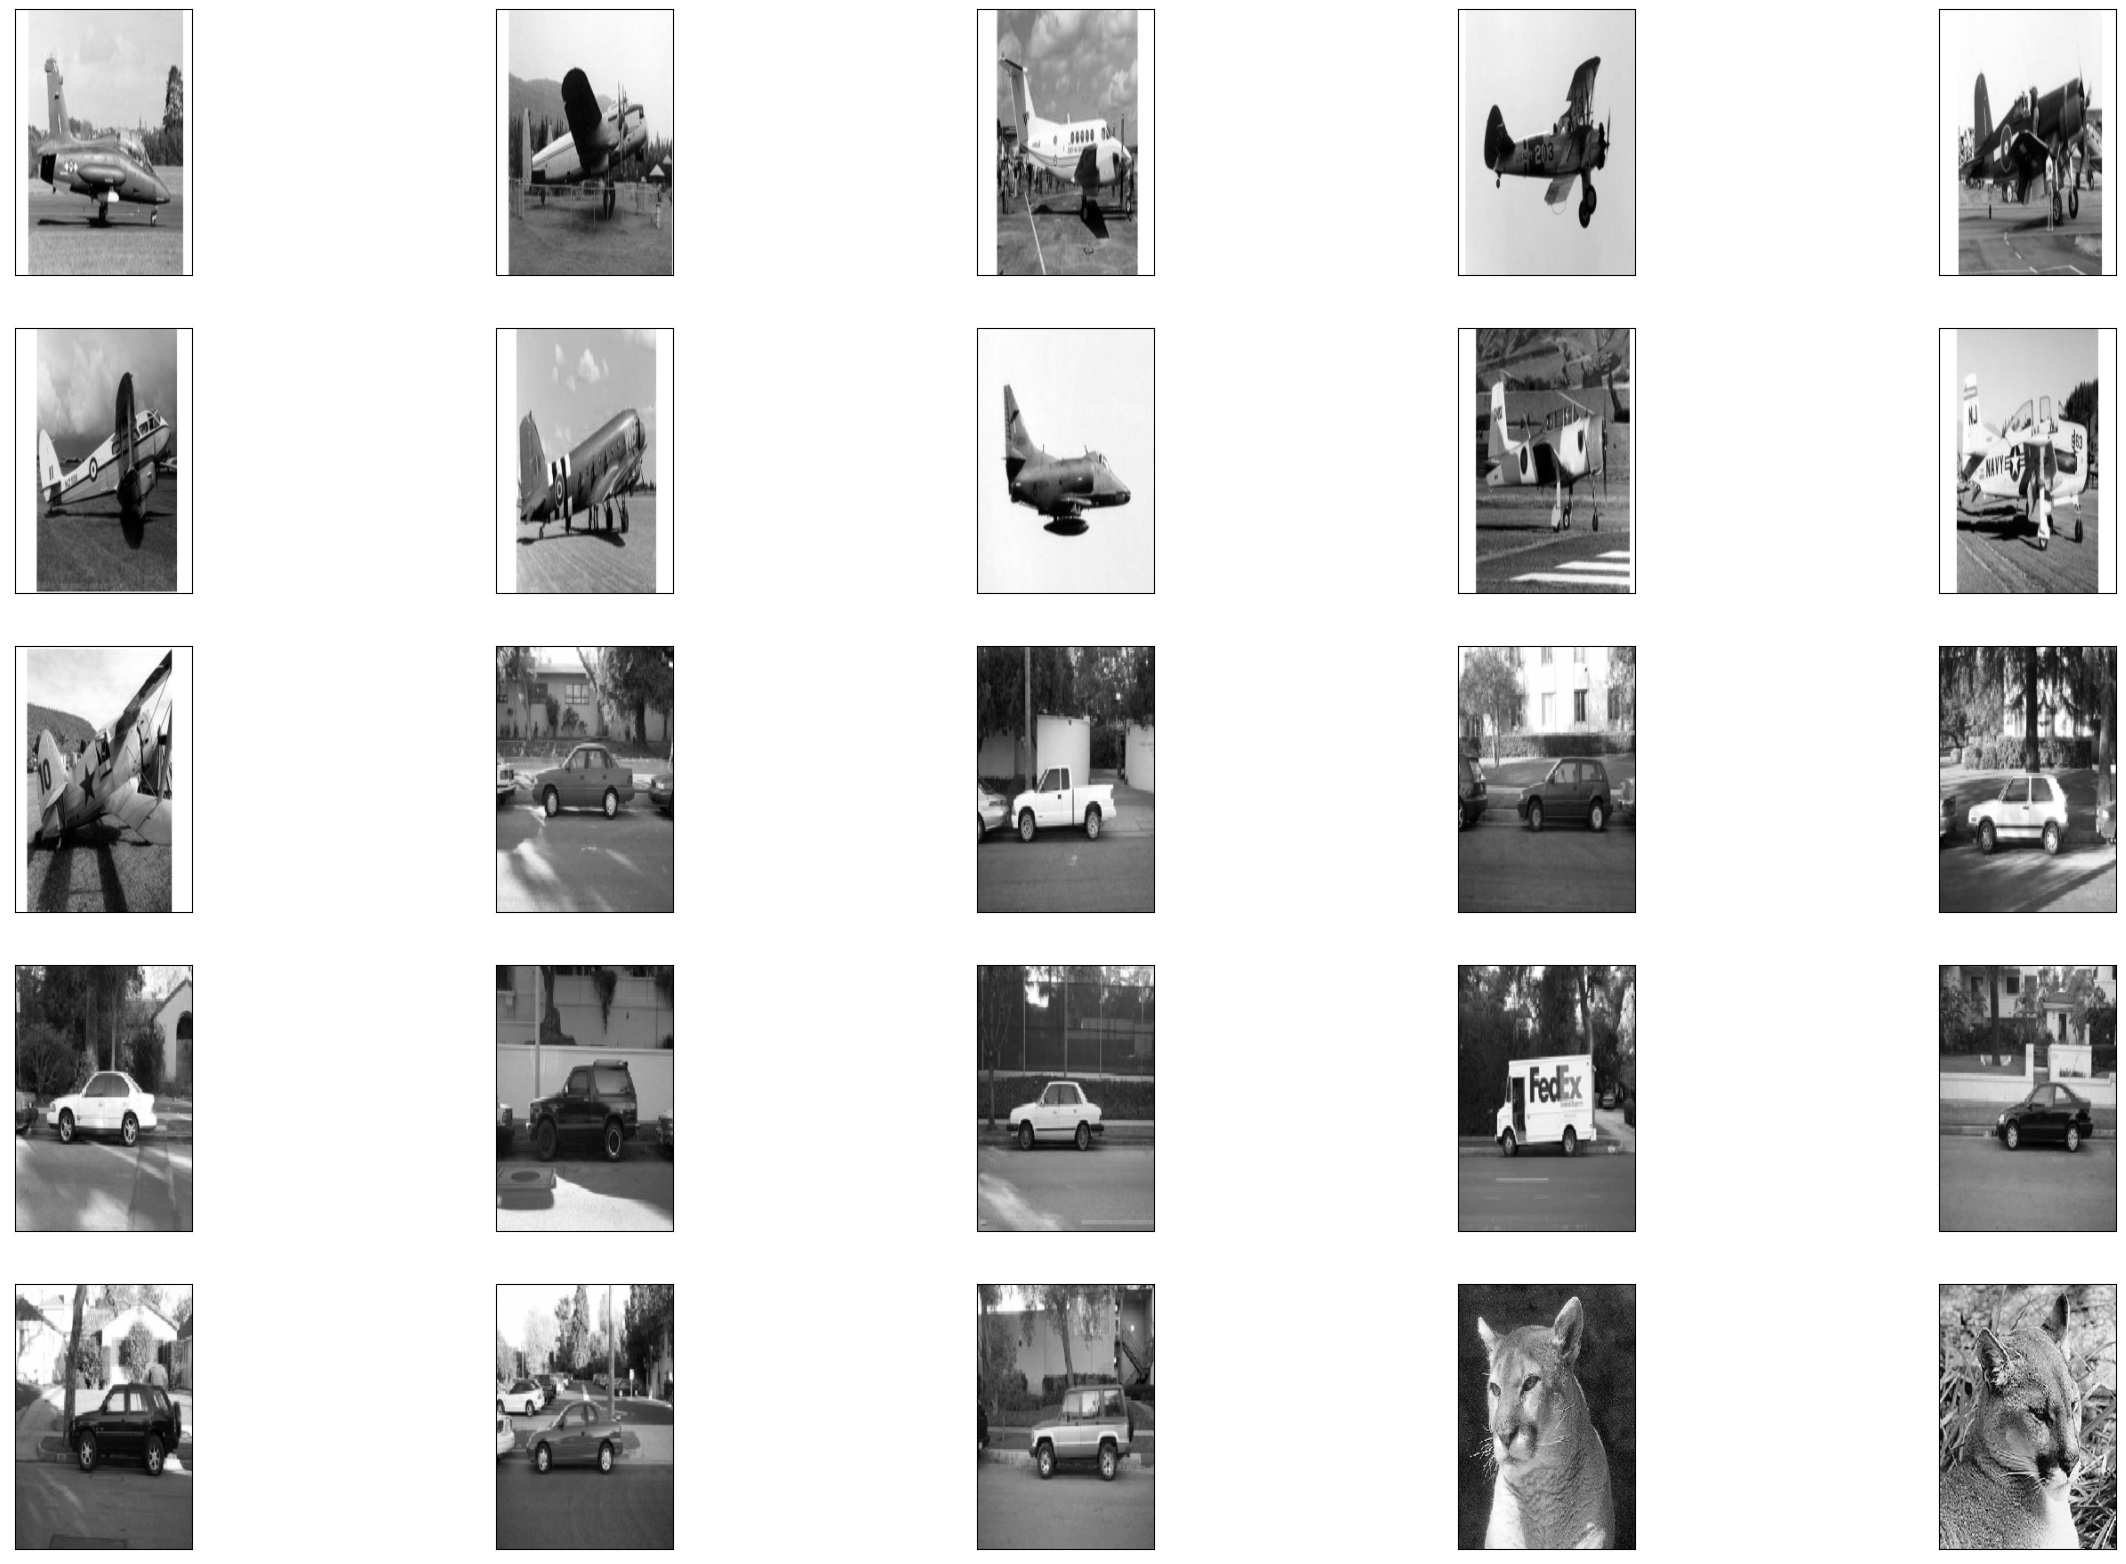

In [637]:
fig, ax = plt.subplots (ncols=5, nrows=5, figsize=(30,20),subplot_kw=dict(xticks=[], yticks=[]));
ax = ax.reshape(25,)
for x in range (25):
    ax[x].imshow(X[x*10].reshape(300,200), cmap='gray')

### II. Feature extraction

#### 2.1.HOG

In [638]:
X_hog=toHog(X_scaled, 
            new_size_x=300, 
            new_size_y=200,
            orientations=20, 
            pixels_per_cell=(38, 38), 
            cells_per_block=(6, 6), 
            visualize=True)

#### 2.2.PCA

In [639]:
pca = PCA(0.9)
X_PCA = pca.fit_transform(X_scaled)

In [640]:
pca.n_components_

101

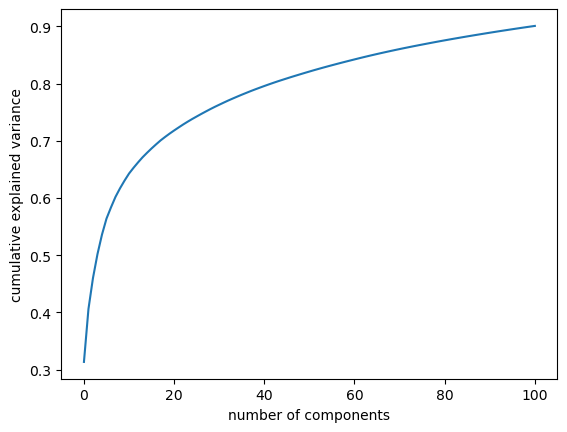

In [641]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### III. Embedding

#### 3.1 TSNE on initial data

In [456]:
X_TSNE = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(X_scaled)

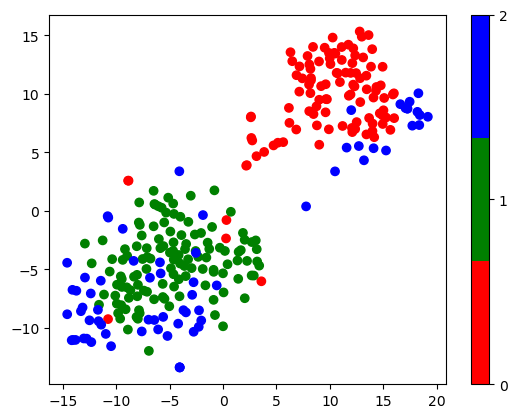

In [457]:
plt.scatter(x=X_TSNE[:,0], 
            y=X_TSNE[:,1],
            c=y, 
            cmap = mpl.colors.ListedColormap(['red', 'green','blue']))
            
plt.colorbar(ticks=[0,1,2],spacing='proportional');

##### Комментарий:

Применение TSNE на сыром наборе данных дает хорошее разделение 1 и 2го кластеров изображений, но практически не кластеризирует 3-й кластер

#### 3.2 TSNE on data after PCA

In [642]:
X_PCA_TSNE = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(X_PCA)

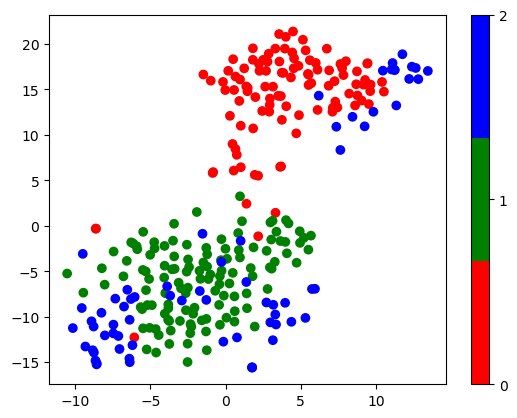

In [643]:
plt.scatter(X_PCA_TSNE[:,0], 
            X_PCA_TSNE[:,1], 
            c=y, 
            cmap = mpl.colors.ListedColormap(['red', 'green','blue']))
plt.colorbar(ticks=[0,1,2],spacing='proportional');

##### Комментарий:

Применение TSNE на наборе после извлечения основных компонент показывает схожий с предыдущим результат

#### 3.3 TSNE on data after HOG

In [620]:
X_hog_TSNE = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(X_hog)

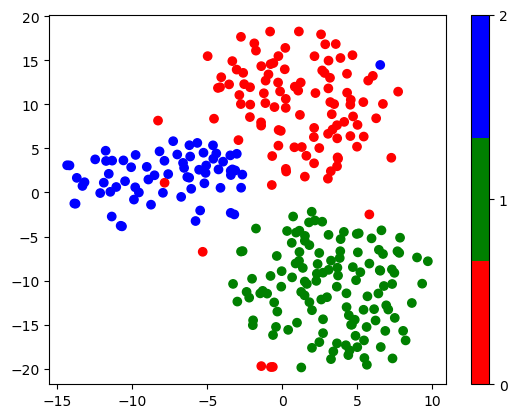

In [622]:
plt.scatter(x=X_hog_TSNE[:,0], 
            y=X_hog_TSNE[:,1],
            c=y, 
            cmap = mpl.colors.ListedColormap(['red', 'green','blue']))
            
plt.colorbar(ticks=[0,1,2],spacing='proportional');

##### Комментарий:

Применение TSNE на наборе HOG преобразования дает практически полную кластеризацию на 3 кластера

### IV. Clusterization

#### 4.1. Кластеризация при помощи KMeans

In [644]:
kmeans=KMeans(n_clusters=3)

#### 4.1.1 KMeans on initial data

In [645]:
k_pred_init = kmeans.fit_predict(X_scaled)
measure(X_scaled,y,
       k_pred_init,
       n_clusters=kmeans.n_clusters)

 For 3 clusters
Silhouetter score is 0.20639913728309076
V_score is 0.42182952392218304


#### 4.1.2 KMeans on data after PCA

In [646]:
k_pred_PCA = kmeans.fit_predict(X_PCA)
measure(X_PCA,y,
       k_pred_PCA,
       n_clusters=kmeans.n_clusters)

 For 3 clusters
Silhouetter score is 0.2290713404709461
V_score is 0.4368017948530047


#### 4.1.3 KMeans on data after TSNE

In [648]:
k_pred_TSNE = kmeans.fit_predict(X_TSNE)
measure(X_TSNE,y,
       k_pred_TSNE,
       n_clusters=kmeans.n_clusters)

 For 3 clusters
Silhouetter score is 0.5051442384719849
V_score is 0.43955460494327975


#### 4.1.4 KMeans on data after HOG

In [649]:
k_pred_hog = kmeans.fit_predict(X_hog)
measure(X_hog,y,
       k_pred_hog,
       n_clusters=kmeans.n_clusters)

 For 3 clusters
Silhouetter score is 0.13487419486045837
V_score is 0.663118464394845


#### 4.1.5 KMeans on data after TSNE+PCA

In [650]:
k_pred_PCA_TSNE = kmeans.fit_predict(X_PCA_TSNE)
measure(X_PCA_TSNE,y,
       k_pred_PCA_TSNE,
       n_clusters=kmeans.n_clusters)

 For 3 clusters
Silhouetter score is 0.4837658703327179
V_score is 0.43346958547316294


#### 4.1.6 KMeans on data after TSNE+HOG  (лучший результат)

In [651]:
k_pred_hog_TSNE = kmeans.fit_predict(X_hog_TSNE)
measure(X_hog_TSNE,y,
       k_pred_hog_TSNE,
       n_clusters=kmeans.n_clusters)

 For 3 clusters
Silhouetter score is 0.5346066355705261
V_score is 0.8349558176242572


#### 4.1.7 Визуализируем центры для лучшей модели.

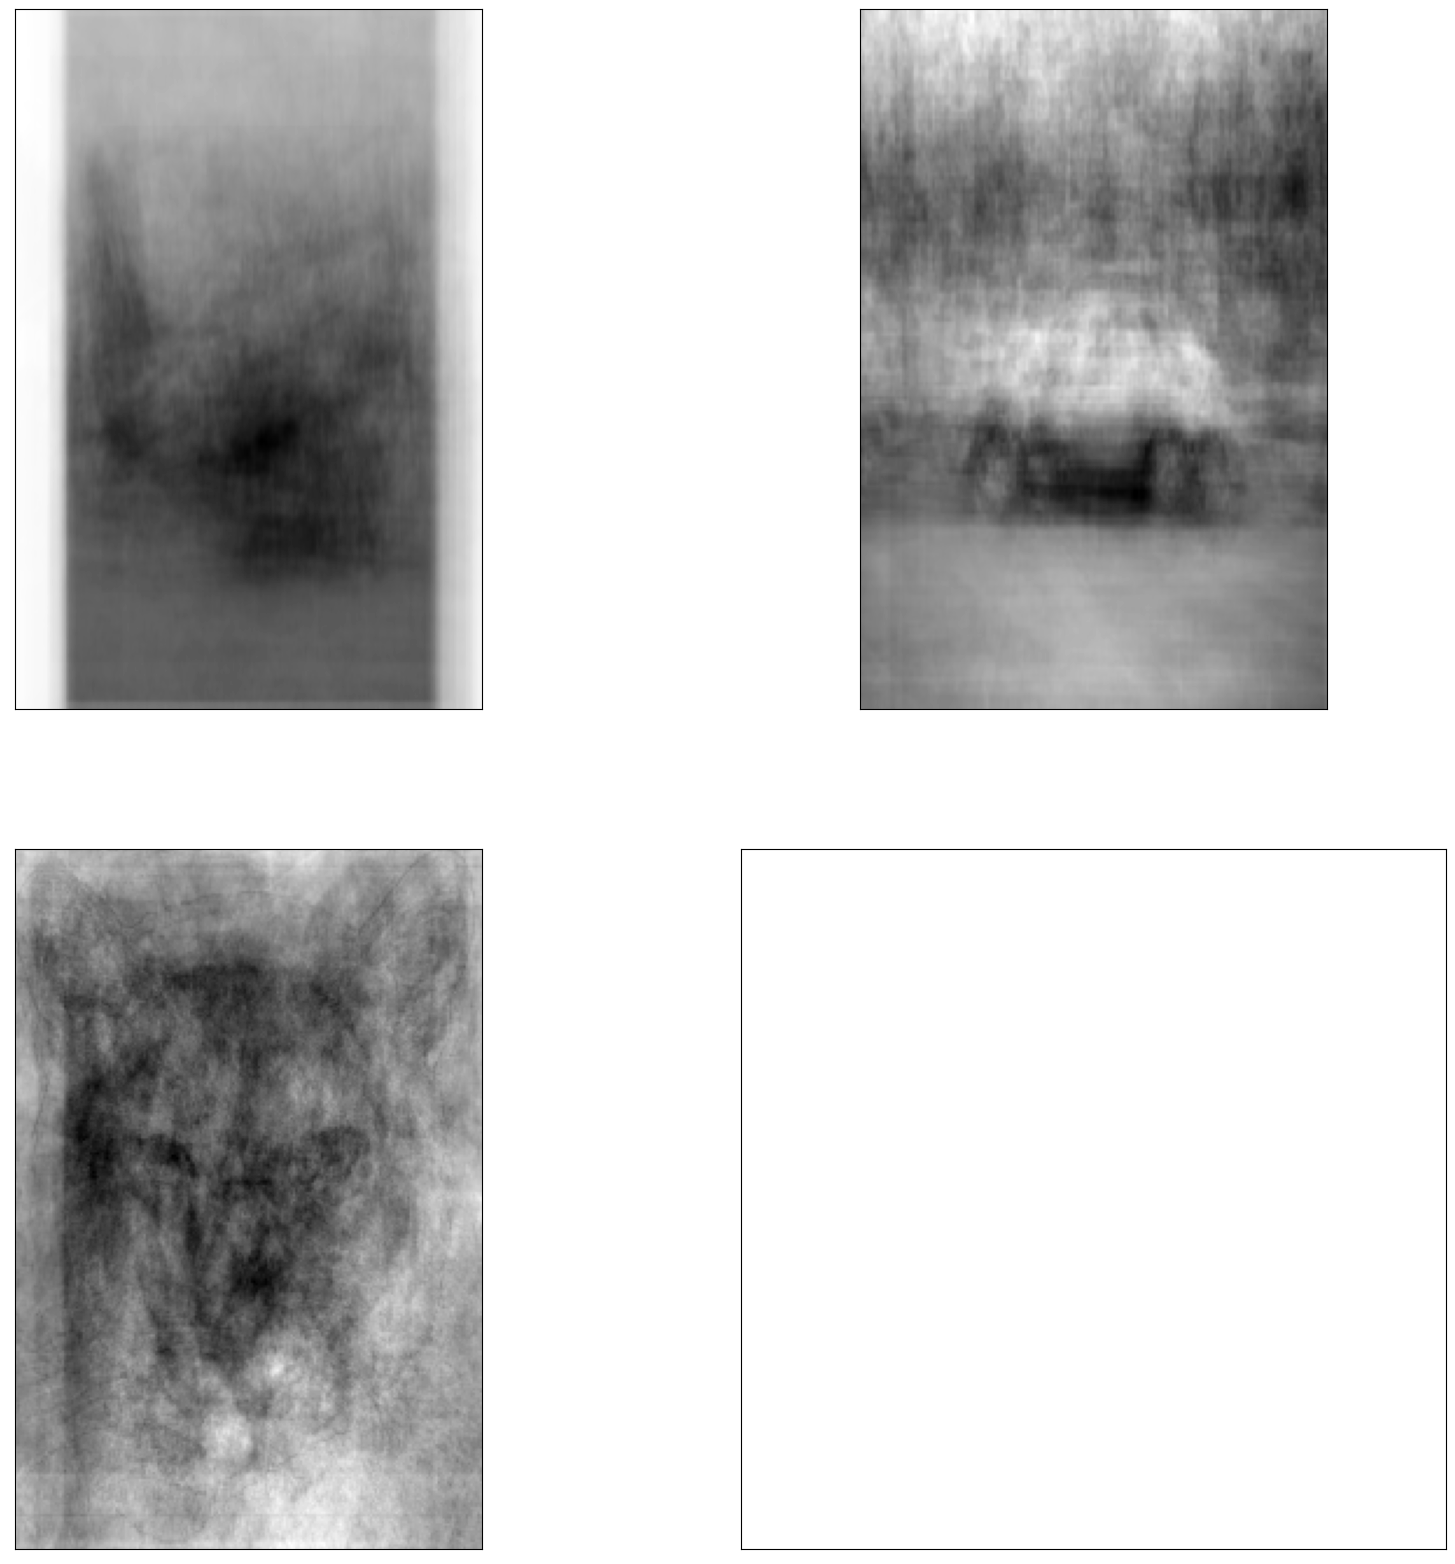

In [653]:
fig, ax = plt.subplots(ncols=2,
                      nrows=2,
                      figsize = (20,20),
                      subplot_kw=dict(xticks=[], yticks=[]))
ax=ax.reshape(4,)

for x in range (3):
    ax[x].imshow(np.mean((X[k_pred_hog_TSNE==x]), axis=0).reshape(300,200), cmap='gray')    

##### Комментарий:

Наилучший результат методом KMEans достигается при применении на выборке преобразованной сочетанием методов HOG + TSNE. При визуализации центров векторов можно видеть отчетливо изображение на 2-м и 3-м кластере (автомобиль и пума), самолет на 1-м кластере узнается с трудом

#### 4.2. Кластеризация при помощи AgglomerativeClustering

In [654]:
aggl = AgglomerativeClustering(n_clusters=3)

#### 4.2.1 AgglomerativeClustering on initial data

In [656]:
aggl_pred_init = aggl.fit_predict(X_scaled)
measure(X_scaled,y,
       aggl_pred_init,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.20781703503140728
V_score is 0.444987344976308


#### 4.2.2 AgglomerativeClustering on data after PCA

In [657]:
aggl_pred_PCA = aggl.fit_predict(X_PCA)
measure(X_PCA,y,
       aggl_pred_PCA,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.23227118831678872
V_score is 0.5282405531221159


#### 4.2.3 AgglomerativeClustering on data after TSNE

In [658]:
aggl_pred_TSNE = aggl.fit_predict(X_TSNE)
measure(X_TSNE,y,
       aggl_pred_TSNE,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.4731646180152893
V_score is 0.47491693504220245


#### 4.2.4 AgglomerativeClustering on data after HOG

In [660]:
aggl_pred_hog = aggl.fit_predict(X_hog)
measure(X_hog,y,
       aggl_pred_hog,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.13042843341827393
V_score is 0.6944490042278859


#### 4.2.5 AgglomerativeClustering on data after TSNE+PCA

In [661]:
aggl_pred_PCA_TSNE = aggl.fit_predict(X_PCA_TSNE)
measure(X_PCA_TSNE,y,
       aggl_pred_PCA_TSNE,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.45782142877578735
V_score is 0.4736679741808551


#### 4.2.6 AgglomerativeClustering on data after TSNE+HOG (лучший результат)

In [662]:
aggl_pred_hog_TSNE = aggl.fit_predict(X_hog_TSNE)
measure(X_hog_TSNE,y,
       aggl_pred_hog_TSNE,
       n_clusters=aggl.n_clusters)

 For 3 clusters
Silhouetter score is 0.5271955728530884
V_score is 0.8250452559095215


#### 4.2.7 Визуализируем центры для лучшей модели.

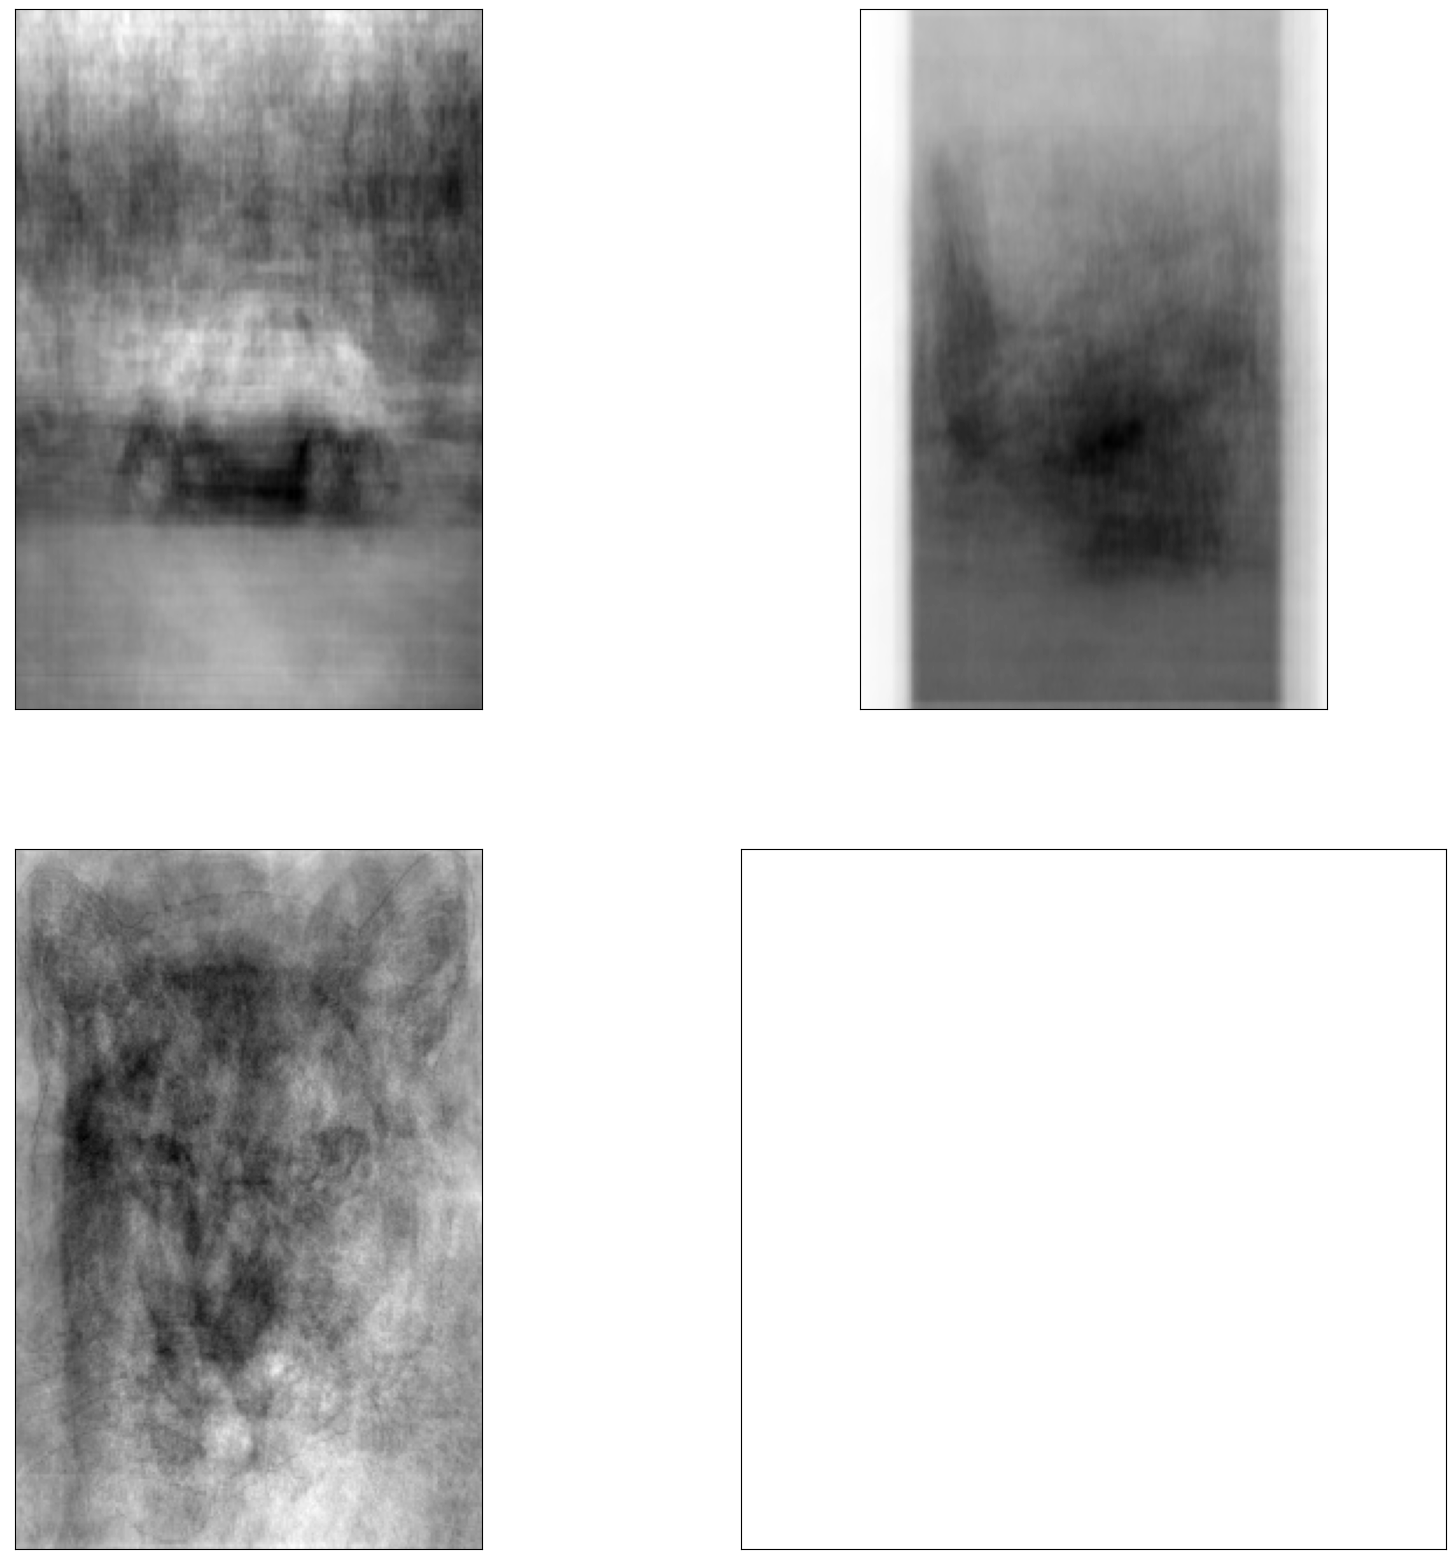

In [663]:
fig, ax = plt.subplots(ncols=2,
                      nrows=2,
                      figsize = (20,20),
                      subplot_kw=dict(xticks=[], yticks=[]))
ax=ax.reshape(4,)

for x in range (3):
    ax[x].imshow(np.mean((X[aggl_pred_hog_TSNE==x]), axis=0).reshape(300,200), cmap='gray')    

##### Комментарий:

Результаты применения метода AgglomarativeClusterng аналогичны предыдущим.

#### Выводы:


1. Применение сочетания методов извлечения признаков и эмбединга позволяет в простых случаях получить достаточно хорошее разделение исходной выборки без кластеризации
2. Наиболее высокие метрики различных методов кластеризации получаются на выборке после HOG+TSNE